# 3 - Machine Learning

Let's use some standard Machine Learning tools available in Python packages to analyse some data.

We have a dataset (from Butterworth et al 2016) with a collection of tectonomagmatic parameters associated with the time and location of porphyry copper deposits. We want to determine which of these (if any) parameters are geologically important (or at least statistically significant) in relation to the formation of porphyry coppers.

Run the next cell to see an animation representing this data


### Now, import most of the modules we need
By convention module loads go at the top of your workflows.

In [1]:
import pandas #For dealing with data structures
import numpy as np #Data array manipulation
import scipy #Scientific Python, has lots of useful tools
import scipy.io #A specific sub-module for input/output of sci data

#scikit-learn tools to perform machine learning classification
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

#For making pretty figures
import matplotlib.pyplot as plt 

#For easy geographic projections on a map
# from mpl_toolkits.basemap import Basemap

#Import a set of tools we have made ourselves
# from Utils_coreg import *

### Now load in the data

In [2]:
#Use pandas to load in the machine learning dataset
ml_data=pandas.read_csv("./Data/ml_data_points.csv", index_col=0)

In [3]:
#Print out the dataset so we can see what it looks like
ml_data

,0 Present day longitude (degrees),1 Present day latitude (degrees),2 Reconstructed longitude (degrees),3 Reconstructed latitude (degrees),4 Age (Ma),5 Time before mineralisation (Myr),6 Seafloor age (Myr),7 Segment length (km),8 Slab length (km),9 Distance to trench edge (km),...,11 Subducting plate parallel velocity (km/Myr),12 Overriding plate normal velocity (km/Myr),13 Overriding plate parallel velocity (km/Myr),14 Convergence normal rate (km/Myr),15 Convergence parallel rate (km/Myr),16 Subduction polarity (degrees),17 Subduction obliquity (degrees),18 Distance along margin (km),19 Subduction obliquity signed (radians),20 Ore Deposits Binary Flag (1 or 0)
0,-66.28,-27.37,-65.264812,-28.103781,6.0,0.0,48.189707,56.08069,2436.30907,2436.30907,...,40.63020,-17.43987,12.20271,102.31471,28.82518,5.67505,15.73415,2269.19769,0.274613,1.0
1,-69.75,-30.50,-67.696759,-31.970639,12.0,0.0,52.321162,56.09672,2490.68735,2490.68735,...,39.60199,-22.80622,13.40127,115.35820,27.39401,5.78937,13.35854,1823.34107,0.233151,1.0
2,-66.65,-27.27,-65.128689,-28.374772,9.0,0.0,53.506085,55.77705,2823.54951,2823.54951,...,45.32425,-18.08485,11.27500,100.24282,34.62444,8.97218,19.05520,2269.19769,0.332576,1.0
3,-66.61,-27.33,-65.257928,-28.311094,8.0,0.0,51.317135,55.90088,2656.71724,2656.71724,...,43.13319,-17.78538,11.72618,101.21965,31.92962,7.42992,17.50782,2269.19769,0.305569,1.0
4,-66.55,-27.40,-65.366917,-28.257580,7.0,0.0,49.340097,56.09011,2547.29585,2547.29585,...,40.57322,-17.43622,12.23778,102.25748,28.80235,5.65657,15.73067,2269.19769,0.274552,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,-78.67,-6.73,-70.657487,-11.057387,39.0,0.0,62.727249,56.14919,5373.67650,1076.30110,...,13.21524,-25.08597,12.24246,60.45651,-7.46828,-22.30925,7.04216,4708.08568,-0.122909,0.0
297,-75.09,-13.69,-37.112536,-19.124363,121.0,0.0,30.740063,54.09642,269.79929,269.79929,...,-39.68330,11.56758,7.99788,-19.41449,-59.05957,-46.36908,71.80290,3761.82099,1.253197,0.0
298,-71.31,-14.91,-38.398992,-21.934657,151.0,0.0,17.739843,53.93117,323.86191,323.86191,...,-3.42257,-17.25992,-22.78837,8.88338,-7.68381,-40.99490,40.85864,3378.69739,-0.713118,0.0
299,-70.61,-17.25,-37.243172,-24.160112,145.0,0.0,11.744395,53.94534,163.59542,163.59542,...,-2.26253,14.87833,0.05195,2.36178,-23.78566,-38.97366,84.32944,3160.06366,-1.471826,0.0


There are 21 columns (python (usually) counts from 0) representing different parameters. Some of these parameters may be useful for us. Some are not. The final column contains a binary flag representing whether there is a known porphyry copper deposit at that location or not. The "non-deposits" are required to train our Machine Learning classifier what a porphyry deposit looks like, and also, what a porphyry deposit doesn't look like!

### Now let's perform our machine learning binary classification.

In [4]:
#Change data format to numpy array for easy manipulation
ml_data_np = ml_data.to_numpy()

#Set the indices of the parameters (features) to include in the ML
params=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# Alternatively try any 4 features you'd like to include!
# params=[6,9,14,17] 


#Save the number of parameters we have chosen
datalength = len(params)

#Normalise the data for Machine Learning
ml_data_norm = preprocessing.scale(ml_data_np[:,params])

#Create a 'feature vector' and a 'target classification vector'
features = ml_data_norm
targets = ml_data_np[:,20]

#Print out some info about our final dataset
print("Shape of ML data array: ", ml_data_norm.shape)
print("Positive (deposits) examples: ",np.shape(ml_data_np[ml_data_np[:,20]==1,:]))
print("Negative (non-deposits) examples: ",np.shape(ml_data_np[ml_data_np[:,20]==0,:]))

ml_data.columns[params]

Shape of ML data array:  (301, 16)
Positive (deposits) examples:  (147, 21)
Negative (non-deposits) examples:  (154, 21)


Index(['4 Age (Ma)', '5 Time before mineralisation (Myr)',
       '6 Seafloor age (Myr)', '7 Segment length (km)', '8 Slab length (km)',
       '9 Distance to trench edge (km)',
       '10 Subducting plate normal velocity (km/Myr)',
       '11 Subducting plate parallel velocity (km/Myr)',
       '12 Overriding plate normal velocity (km/Myr)',
       '13 Overriding plate parallel velocity (km/Myr)',
       '14 Convergence normal rate (km/Myr)',
       '15 Convergence parallel rate (km/Myr)',
       '16 Subduction polarity (degrees)', '17 Subduction obliquity (degrees)',
       '18 Distance along margin (km)',
       '19 Subduction obliquity signed (radians)'],
      dtype='object')

In [5]:
print('Make the classifiers')

print('Random Forest...')
#create and train the random forest
#multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
#n_estimators use between 64-128 doi: 10.1007/978-3-642-31537-4_13
rf = RandomForestClassifier(n_estimators=128, n_jobs=1,class_weight=None)
rf.fit(features,targets)
print("Done RF")

print("R2 score %.4f" % rf.score(features,targets))

scores = cross_validate(rf, features, targets, cv=10)
print("RF Scores: \n",scores['test_score'])
print("SCORE Mean: %.2f" % np.mean(scores['test_score']), "STD: %.2f" % np.std(scores['test_score']), "\n")


Make the classifiers
Random Forest...
Done RF
R2 score 0.9934
RF Scores: 
 [0.64516129 0.7        0.8        0.63333333 0.73333333 0.53333333
 0.5        0.76666667 0.76666667 0.8       ]
SCORE Mean: 0.69 STD: 0.10 



Importance 	 Feature
0.122 		 4 Age (Ma)
0.000 		 5 Time before mineralisation (Myr)
0.105 		 6 Seafloor age (Myr)
0.060 		 7 Segment length (km)
0.073 		 8 Slab length (km)
0.083 		 9 Distance to trench edge (km)
0.056 		 10 Subducting plate normal velocity (km/Myr)
0.053 		 11 Subducting plate parallel velocity (km/Myr)
0.075 		 12 Overriding plate normal velocity (km/Myr)
0.050 		 13 Overriding plate parallel velocity (km/Myr)
0.062 		 14 Convergence normal rate (km/Myr)
0.048 		 15 Convergence parallel rate (km/Myr)
0.049 		 16 Subduction polarity (degrees)
0.071 		 17 Subduction obliquity (degrees)
0.043 		 18 Distance along margin (km)
0.051 		 19 Subduction obliquity signed (radians)


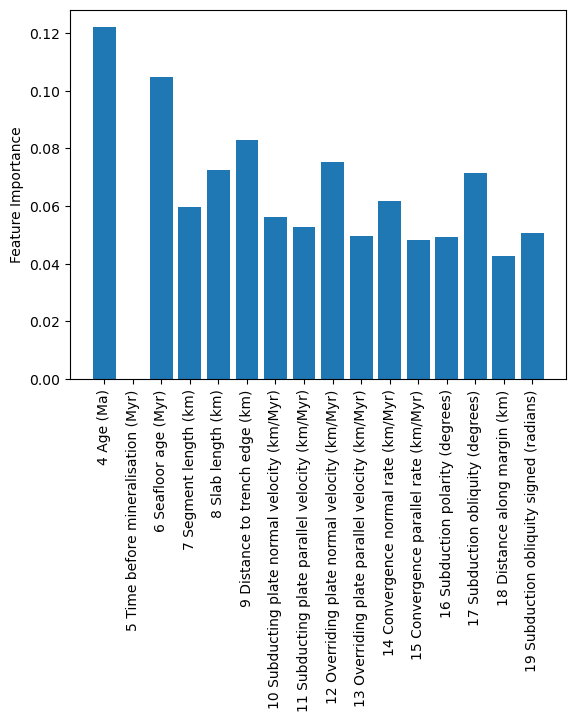

In [6]:
#Make a list of labels for our chosen features
paramColumns=np.array(ml_data.columns)
paramLabels=paramColumns[params].tolist()

#Create a new figure
fig, ax = plt.subplots()

#Plot the bar graph
rects=ax.bar(np.arange(0, datalength, step=1),rf.feature_importances_)

#Label the axes
ax.set_xticks(np.arange(0, datalength, step=1))
ax.set_xticklabels(paramLabels,rotation=90)
ax.set_ylabel('Feature Importance')

#Print the feature importance to compare with plot
np.set_printoptions(precision=3,suppress=True)
print("Importance \t Feature")
for i,label in enumerate(paramLabels):
    print("%1.3f \t\t %s" % (rf.feature_importances_[i],label))

plt.show()


Now if we can measure the tectonomagmatic properties at some point. Based on our trained classifer we can predict a probability that porphyry copper deposits have formed

In [7]:
#Apply the trained ML to our gridded data to determine the probabilities at each of the points
print('RF...')
pRF = np.array(rf.predict_proba(features))
print("Done RF")

RF...
Done RF


## Map!

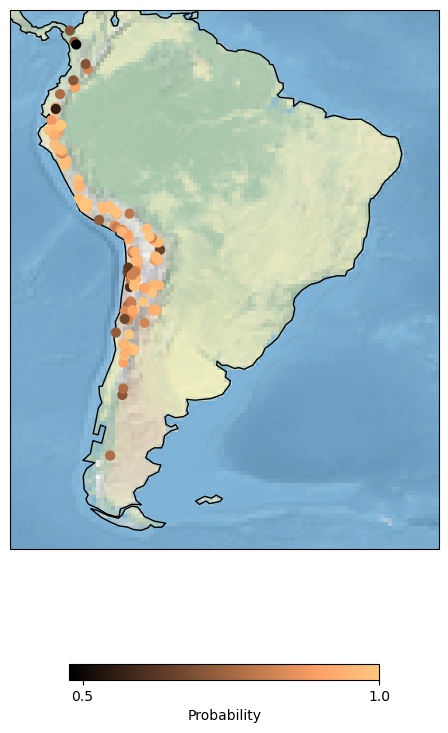

In [8]:
import cartopy
import cartopy.crs as ccrs


fig = plt.figure(figsize=(8, 10), facecolor="none")
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-85,-30,-55,10])

ax.stock_img()
ax.coastlines()


#Plot the ore deposit probability
xh, yh = ml_data_np[ml_data_np[:,-1]==1,0], ml_data_np[ml_data_np[:,-1]==1,1]
ln1 = ax.scatter(xh, yh, s=40, c=pRF[:147,1], cmap=plt.cm.copper, zorder=3, transform=ccrs.PlateCarree())
cb3=fig.colorbar(ln1, ticks=[0,0.5,1], label='Probability', orientation='horizontal', shrink=0.5)

plt.show()